In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/import-and-export-by-india/PC_Export_2015_2016.csv
/kaggle/input/import-and-export-by-india/PC_Export_2014_2015.csv
/kaggle/input/import-and-export-by-india/PC_Export_2016_2017.csv
/kaggle/input/import-and-export-by-india/PC_Import_2016_2017.csv
/kaggle/input/import-and-export-by-india/PC_Import_2015_2016.csv
/kaggle/input/import-and-export-by-india/PC_Import_2014_2015.csv
/kaggle/input/creditcardfraud/creditcard.csv
/kaggle/input/adult-census-income/adult.csv
/kaggle/input/2019-autonomous-vehicle-disengagement-reports/2019AutonomousVehicleDisengagementReports.csv
/kaggle/input/2019-autonomous-vehicle-disengagement-reports/2018-19_AutonomousVehicleDisengagementReports(firsttimefilers).csv
/kaggle/input/heart-disease-health-indicators-dataset/heart_disease_health_indicators_BRFSS2015.csv


In [2]:
dir_list = os.listdir('../input')
dir_list

['import-and-export-by-india',
 'creditcardfraud',
 'adult-census-income',
 '2019-autonomous-vehicle-disengagement-reports',
 'heart-disease-health-indicators-dataset']

**Define Models to be used for Synthetic Data Generation - CTGAN and TVAE**

In [3]:
import time

import warnings
warnings.filterwarnings('ignore')

In [4]:
pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 KB 328.3 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 KB 1.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 KB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.6/636.6 KB 12.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.3 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pi

In [5]:
from sdv.tabular import TVAE
from sdv.tabular import CTGAN
from sdv.evaluation import evaluate

models_tvae = []
models_ctgan = []

for i in range(6):
    models_ctgan.append(CTGAN(batch_size=300, verbose=True, epochs=80))
    models_tvae.append(TVAE(batch_size=300, epochs=80))

In [6]:
df1 = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
df1.name = "adult-census-income"

df2a = pd.read_csv("/kaggle/input/import-and-export-by-india/PC_Import_2016_2017.csv")
df2a.name = "india-import-2017"
df2b = pd.read_csv("/kaggle/input/import-and-export-by-india/PC_Export_2016_2017.csv")
df2b.name = "india-export-2017"

df3 = pd.read_csv("/kaggle/input/heart-disease-health-indicators-dataset/heart_disease_health_indicators_BRFSS2015.csv")
df3.name = "heart-disease-health-indicators-dataset"
df4 = pd.read_csv("/kaggle/input/2019-autonomous-vehicle-disengagement-reports/2019AutonomousVehicleDisengagementReports.csv")
df4.name = "autonomous-vehicle-disengagement"
df5 = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df5.name = "creditcardfraud"


In [7]:
dfs = [df1, df2a, df2b, df3, df4, df5]

# To store generated synthetic data
synthetic_data_mapping = {}

metrics=['CSTest', 'KSTest', 'ContinuousKLDivergence', 'DiscreteKLDivergence']
saved_models = {}

In [8]:
for df in dfs:
    print('\n' + '%'*40)
    print('\033[1m' + df.name + '\033[0m')
    print('%'*40 + '\n')
    df.info()
    display(df.head())
    synthetic_data_mapping[df.name] = []


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
adult-census-income
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usag

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
india-import-2017
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9694 entries, 0 to 9693
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pc_code         9694 non-null   object 
 1   pc_description  9694 non-null   object 
 2   unit            9694 non-null   object 
 3   country_code    9694 non-null   int64  
 4   country_name    9694 non-null   object 
 5   quantity        4327 non-null   float64
 6   value           9694 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 530.3+ KB


,pc_code,pc_description,unit,country_code,country_name,quantity,value
0,99,Other Commodities,Na,599,Unspecified,NaN,6994.362548
1,99,Other Commodities,Na,1213,Kenya,NaN,3.058141
2,99,Other Commodities,Na,1395,Tanzania Rep,NaN,7.582766
3,99,Other Commodities,Na,1417,Uganda,NaN,0.000057
4,99,Other Commodities,Na,2035,Benin,NaN,5.537281



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
india-export-2017
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20844 entries, 0 to 20843
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pc_code         20844 non-null  object 
 1   pc_description  20844 non-null  object 
 2   unit            20844 non-null  object 
 3   country_code    20844 non-null  int64  
 4   country_name    20844 non-null  object 
 5   quantity        10065 non-null  float64
 6   value           20844 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ MB


,pc_code,pc_description,unit,country_code,country_name,quantity,value
0,99,Other Commodities,Na,599,Unspecified,NaN,270.889542
1,99,Other Commodities,Na,1213,Kenya,NaN,17.159452
2,99,Other Commodities,Na,1395,Tanzania Rep,NaN,8.896539
3,99,Other Commodities,Na,1417,Uganda,NaN,5.181412
4,99,Other Commodities,Na,2035,Benin,NaN,2.476015



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
heart-disease-health-indicators-dataset
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
autonomous-vehicle-disengagement
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8885 entries, 0 to 8884
Data columns (total 9 columns):
 #   Column                                                                                          Non-Null Count  Dtype 
---  ------                                                                                          --------------  ----- 
 0   Manufacturer                                                                                    8885 non-null   object
 1   Permit Number                                                                                   8885 non-null   object
 2   DATE                                                                                            8884 non-null   object
 3   VIN NUMBER                                                                                      8884 non-null   object
 4   VEHICLE IS CAPABLE OF OPERAT

,Manufacturer,Permit Number,DATE,VIN NUMBER,VEHICLE IS CAPABLE OF OPERATING WITHOUT A DRIVER\n(Yes or No),DRIVER PRESENT\n(Yes or No),"DISENGAGEMENT INITIATED BY\n(AV System, Test Driver, Remote Operator, or Passenger)","DISENGAGEMENT\nLOCATION\n(Interstate, Freeway, Highway, Rural Road, Street, or Parking Facility)",DESCRIPTION OF FACTS CAUSING DISENGAGEMENT
0,AImotive Inc.,AVT003,12.06.2018,JTDKN3DU5A1092792,No,Yes,Test Driver,Freeway,"Lane change maneuver: risk of lane departure, ..."
1,AImotive Inc.,AVT003,12.10.2018,JTDKN3DU5A1092792,No,Yes,Test Driver,Freeway,"Lane change maneuver: risk of lane departure, ..."
2,AImotive Inc.,AVT003,12.10.2018,JTDKN3DU5A1092792,No,Yes,Test Driver,Freeway,"Lane change maneuver: risk of lane departure, ..."
3,AImotive Inc.,AVT003,04.23.2019,JTDKN3DU5A1092792,No,Yes,Test Driver,Freeway,"Lane change maneuver: risk of lane departure, ..."
4,AImotive Inc.,AVT003,05.14.2019,JTDKN3DU5A1092792,No,Yes,Test Driver,Freeway,Lane change maneuver to the exit lane: risk of...



%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
creditcardfraud
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null 

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
dfs=[df1, df3, df4]

In [10]:

def evaluate_model(model, df):
    
    print('Training in Progress - ' + model.__class__.__name__ + '-' + df.name + '\n')
    
    # Record training time
    start = time.time()
    model.fit(df)
    end = time.time()
    
    print( '\n' + model.__class__.__name__ + ' trained. \nTraining time: ' + str(end-start) + ' seconds \n')
    syn_data = model.sample(len(df))
    syn_data.name = df.name + '-' + model.__class__.__name__
    synthetic_data_mapping[df.name].append(syn_data)    
    
    # Record evaluation time
    start = time.time()
    ee = evaluate(syn_data, df, metrics=metrics , aggregate=False)
    end = time.time()
    print("Synthetic Data Evaluation - " +  model.__class__.__name__ + '-' + df.name + '\n')
    display(ee)
    print('\nEvaluation time: ' + str(end-start) + ' seconds \n')
    
    
    # Save the model
    saved_model_name = model.__class__.__name__ + '-' + df.name + '.pkl'
    model.save(saved_model_name)
    saved_models[saved_model_name] = model

In [11]:
k = 0;
for df in dfs:
    evaluate_model(models_ctgan[k], df)
    evaluate_model(models_tvae[k], df)
    k += 1

Training in Progress - CTGAN-adult-census-income

Epoch 1, Loss G:  1.3442,Loss D: -0.0454
Epoch 2, Loss G:  1.1485,Loss D:  0.0977
Epoch 3, Loss G:  0.7032,Loss D:  0.0100
Epoch 4, Loss G:  0.2539,Loss D:  0.0669
Epoch 5, Loss G: -0.2268,Loss D:  0.0054
Epoch 6, Loss G: -0.6343,Loss D:  0.1410
Epoch 7, Loss G: -0.6710,Loss D:  0.0306
Epoch 8, Loss G: -0.7792,Loss D: -0.1591
Epoch 9, Loss G: -0.9075,Loss D: -0.2300
Epoch 10, Loss G: -0.9155,Loss D: -0.1571
Epoch 11, Loss G: -1.0656,Loss D: -0.1547
Epoch 12, Loss G: -0.7991,Loss D: -0.4291
Epoch 13, Loss G: -0.8310,Loss D: -0.2345
Epoch 14, Loss G: -0.7001,Loss D:  0.0648
Epoch 15, Loss G: -0.7955,Loss D: -0.1854
Epoch 16, Loss G: -0.7184,Loss D: -0.0833
Epoch 17, Loss G: -0.7898,Loss D: -0.3653
Epoch 18, Loss G: -0.5319,Loss D: -0.1800
Epoch 19, Loss G: -0.9450,Loss D: -0.0585
Epoch 20, Loss G: -1.2596,Loss D: -0.0332
Epoch 21, Loss G: -0.7742,Loss D: -0.0842
Epoch 22, Loss G: -0.5281,Loss D: -0.0591
Epoch 23, Loss G: -0.6217,Loss D: -

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.974517,0.974517,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.845121,0.845121,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.922216,0.922216,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.874645,0.874645,0.0,1.0,MAXIMIZE,None



Evaluation time: 2.637301445007324 seconds 

Training in Progress - TVAE-adult-census-income


TVAE trained. 
Training time: 128.97127556800842 seconds 

Synthetic Data Evaluation - TVAE-adult-census-income



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.991284,0.991284,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.824939,0.824939,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.857514,0.857514,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.916447,0.916447,0.0,1.0,MAXIMIZE,None



Evaluation time: 2.672351360321045 seconds 

Training in Progress - CTGAN-heart-disease-health-indicators-dataset

Epoch 1, Loss G: -2.7677,Loss D: -0.0474
Epoch 2, Loss G: -3.2349,Loss D:  0.1068
Epoch 3, Loss G: -3.2406,Loss D:  0.0399
Epoch 4, Loss G: -3.2651,Loss D: -0.0686
Epoch 5, Loss G: -3.1486,Loss D:  0.1105
Epoch 6, Loss G: -3.2782,Loss D:  0.2928
Epoch 7, Loss G: -3.0772,Loss D:  0.0338
Epoch 8, Loss G: -3.8298,Loss D:  0.2758
Epoch 9, Loss G: -4.0843,Loss D:  0.1587
Epoch 10, Loss G: -3.9371,Loss D:  0.0175
Epoch 11, Loss G: -4.0718,Loss D: -0.2991
Epoch 12, Loss G: -4.0376,Loss D:  0.1746
Epoch 13, Loss G: -3.9511,Loss D:  0.3171
Epoch 14, Loss G: -4.0661,Loss D: -0.2971
Epoch 15, Loss G: -3.8825,Loss D:  0.0066
Epoch 16, Loss G: -4.2516,Loss D: -0.0111
Epoch 17, Loss G: -4.1838,Loss D:  0.0642
Epoch 18, Loss G: -4.1229,Loss D:  0.3780
Epoch 19, Loss G: -4.2990,Loss D: -0.0669
Epoch 20, Loss G: -3.9893,Loss D:  0.3514
Epoch 21, Loss G: -4.0126,Loss D: -0.0797
Epoch 22, L

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.922030,0.922030,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.933002,0.933002,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."



Evaluation time: 13.537958860397339 seconds 

Training in Progress - TVAE-heart-disease-health-indicators-dataset


TVAE trained. 
Training time: 1131.6396474838257 seconds 

Synthetic Data Evaluation - TVAE-heart-disease-health-indicators-dataset



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.908134,0.908134,0.0,1.0,MAXIMIZE,None
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,0.873983,0.873983,0.0,1.0,MAXIMIZE,None
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."



Evaluation time: 13.44017243385315 seconds 

Training in Progress - CTGAN-autonomous-vehicle-disengagement

Epoch 1, Loss G:  3.5570,Loss D: -0.5031
Epoch 2, Loss G:  3.2590,Loss D: -0.2586
Epoch 3, Loss G:  3.2191,Loss D: -0.0609
Epoch 4, Loss G:  2.9035,Loss D: -0.0059
Epoch 5, Loss G:  2.5548,Loss D:  0.0248
Epoch 6, Loss G:  2.7343,Loss D: -0.0407
Epoch 7, Loss G:  2.4541,Loss D: -0.0166
Epoch 8, Loss G:  2.4245,Loss D:  0.0285
Epoch 9, Loss G:  2.5492,Loss D: -0.0609
Epoch 10, Loss G:  2.0881,Loss D: -0.0325
Epoch 11, Loss G:  2.2158,Loss D: -0.0717
Epoch 12, Loss G:  2.2822,Loss D: -0.0539
Epoch 13, Loss G:  2.0567,Loss D: -0.1005
Epoch 14, Loss G:  1.9632,Loss D: -0.0545
Epoch 15, Loss G:  2.0791,Loss D: -0.1347
Epoch 16, Loss G:  1.9557,Loss D: -0.1288
Epoch 17, Loss G:  1.9760,Loss D: -0.0966
Epoch 18, Loss G:  1.9954,Loss D: -0.0842
Epoch 19, Loss G:  2.0668,Loss D: -0.0476
Epoch 20, Loss G:  1.6616,Loss D: -0.0651
Epoch 21, Loss G:  1.6974,Loss D: -0.0095
Epoch 22, Loss G: 

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.991706,0.991706,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('numerical',)"
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('numerical',)"
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.249654,0.249654,0.0,1.0,MAXIMIZE,None



Evaluation time: 5.599902629852295 seconds 

Training in Progress - TVAE-autonomous-vehicle-disengagement


TVAE trained. 
Training time: 20.41316318511963 seconds 

Synthetic Data Evaluation - TVAE-autonomous-vehicle-disengagement



,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,0.998068,0.998068,0.0,1.0,MAXIMIZE,None
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('numerical',)"
2,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('numerical',)"
3,DiscreteKLDivergence,Discrete Kullback–Leibler Divergence,0.310909,0.310909,0.0,1.0,MAXIMIZE,None



Evaluation time: 3.418523073196411 seconds 



In [12]:
saved_models

{'CTGAN-adult-census-income.pkl': <sdv.tabular.ctgan.CTGAN at 0x7f37fb963210>,
 'TVAE-adult-census-income.pkl': <sdv.tabular.ctgan.TVAE at 0x7f37fb963350>,
 'CTGAN-heart-disease-health-indicators-dataset.pkl': <sdv.tabular.ctgan.CTGAN at 0x7f383aff9dd0>,
 'TVAE-heart-disease-health-indicators-dataset.pkl': <sdv.tabular.ctgan.TVAE at 0x7f373f0f1d10>,
 'CTGAN-autonomous-vehicle-disengagement.pkl': <sdv.tabular.ctgan.CTGAN at 0x7f373f07b110>,
 'TVAE-autonomous-vehicle-disengagement.pkl': <sdv.tabular.ctgan.TVAE at 0x7f373f07b210>}

In [13]:
synthetic_data_mapping[df1.name][0].head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,46,Private,285580,9th,6,Separated,Other-service,Unmarried,Black,Female,0,0,40,?,<=50K
1,45,?,161149,Some-college,10,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K
2,28,State-gov,106331,Bachelors,13,Never-married,Exec-managerial,Not-in-family,Asian-Pac-Islander,Female,0,1,40,?,<=50K
3,52,Private,101797,Assoc-voc,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,33,United-States,<=50K
4,21,Private,197552,Some-college,10,Never-married,Craft-repair,Not-in-family,White,Male,12,0,40,?,<=50K


In [14]:
synthetic_data_mapping[df1.name][1].name

'adult-census-income-TVAE'

**Visualisation**

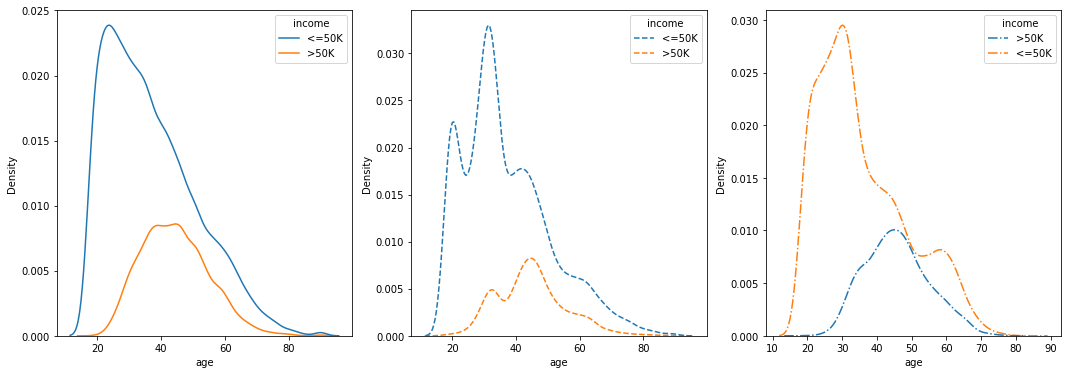

In [72]:
import seaborn as sns
from matplotlib import pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
sns.kdeplot(data=df1,ax=ax0, x='age', hue='income')
sns.kdeplot(data=synthetic_data_mapping[df1.name][0],ax=ax1, x='age', hue='income', label='ctgan', ls='--')
sns.kdeplot(data=synthetic_data_mapping[df1.name][1],ax=ax2, x='age', hue='income', label='tvae', ls='-.')
plt.show()

In [63]:
obj_data = df1.select_dtypes(include=['object']).copy()
obj_data.head()

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
0,?,HS-grad,Widowed,?,Not-in-family,White,Female,United-States,<=50K
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female,United-States,<=50K
2,?,Some-college,Widowed,?,Unmarried,Black,Female,United-States,<=50K
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female,United-States,<=50K
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female,United-States,<=50K


In [73]:

"""fig2, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 6))
sns.catplot(ax=ax0, x="education", kind="count", palette="ch:.25", data=df1)
sns.catplot(ax=ax1, x="education", kind="count", palette="ch:.25", data=synthetic_data_mapping[df1.name][0])
sns.catplot(ax=ax2, x="education", kind="count", palette="ch:.25", data=synthetic_data_mapping[df1.name][1])
plt.show()"""

'fig2, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 6))\nsns.catplot(ax=ax0, x="education", kind="count", palette="ch:.25", data=df1)\nsns.catplot(ax=ax1, x="education", kind="count", palette="ch:.25", data=synthetic_data_mapping[df1.name][0])\nsns.catplot(ax=ax2, x="education", kind="count", palette="ch:.25", data=synthetic_data_mapping[df1.name][1])\nplt.show()'

In [60]:
synthetic_data_mapping[df1.name][1].groupby(['income']).size()

income
<=50K    24998
>50K      7563
dtype: int64

In [61]:
synthetic_data_mapping[df1.name][0].groupby(['income']).size()

income
<=50K    26731
>50K      5830
dtype: int64

In [62]:
df1.groupby('income').size()

income
<=50K    24720
>50K      7841
dtype: int64

In [18]:
# VBGMM
from sklearn.mixture import GaussianMixture

vbgmm = GaussianMixture(n_components=3, random_state=42)
col = df1['education.num'].values.reshape(-1,1)
vbg = vbgmm.fit(col)
vbg.means_.shape
vbg.means_

array([[ 9.45084037],
       [13.16587431],
       [ 5.65350733]])

**VAE for Adult Census Data**

In [19]:
"""# select categorical data
obj_data = df1.select_dtypes(include=['object']).copy()
# List details of categories for each categorical data
for col in obj_data.columns:

    print('\n'+col+'\n')
    print(obj_data[col].value_counts())"""

"# select categorical data\nobj_data = df1.select_dtypes(include=['object']).copy()\n# List details of categories for each categorical data\nfor col in obj_data.columns:\n\n    print('\n'+col+'\n')\n    print(obj_data[col].value_counts())"

In [20]:
#df1['age'].value_counts().sort_values

In [21]:
"""from sklearn.preprocessing import OrdinalEncoder

raw_data = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")
raw_data.head()

raw_data.shape

# Count total null values in each column
data = raw_data.replace("?", np.nan)
data.isnull().sum(axis=0)

data.dtypes

# Remove Null values from columns
data = data.dropna()

# Rename columns as per python naming convention
data = data.rename(columns={"education.num": "education_num",
                            "marital.status": "marital_status", 
                           "capital.gain": "capital_gain", 
                           "capital.loss": "capital_loss", 
                           "hours.per.week": "hours_per_week",
                           "native.country": "native_country"})
data.head()

# Find correlation b/w variables
data.corr()

# select categorical data
obj_data = data.select_dtypes(include=['object']).copy()
obj_data.head()

# List details of categories for each categorical data
for col in obj_data.columns:

    print('\n'+col+'\n')
    print(obj_data[col].value_counts())
    
# Encoder
enc = OrdinalEncoder()

# Encode all categorical variables
def encode_categorical_cols(df):
    # List of categorical columns
    obj_cols = list(df.columns)

    for col in obj_cols:
        # Encode and make new column with _code appended
        df[col+'_code'] = enc.fit_transform(df[[col]])
    return df
        

enc_obj_data = encode_categorical_cols(obj_data)
enc_obj_data.head(10)"""

'from sklearn.preprocessing import OrdinalEncoder\n\nraw_data = pd.read_csv("/kaggle/input/adult-census-income/adult.csv")\nraw_data.head()\n\nraw_data.shape\n\n# Count total null values in each column\ndata = raw_data.replace("?", np.nan)\ndata.isnull().sum(axis=0)\n\ndata.dtypes\n\n# Remove Null values from columns\ndata = data.dropna()\n\n# Rename columns as per python naming convention\ndata = data.rename(columns={"education.num": "education_num",\n                            "marital.status": "marital_status", \n                           "capital.gain": "capital_gain", \n                           "capital.loss": "capital_loss", \n                           "hours.per.week": "hours_per_week",\n                           "native.country": "native_country"})\ndata.head()\n\n# Find correlation b/w variables\ndata.corr()\n\n# select categorical data\nobj_data = data.select_dtypes(include=[\'object\']).copy()\nobj_data.head()\n\n# List details of categories for each categorical data\n

In [22]:
"""
enc_obj_data.columns

data.shape

obj_data.shape

enc_obj_data.shape

merged_df = pd.concat([data, enc_obj_data], axis=1, join="inner", ignore_index=False)
merged_df.head()

merged_df.shape

merged_df = merged_df.loc[:,~merged_df.columns.duplicated()]
merged_df.shape

merged_df.dtypes

merged_df.head()"""

'\nenc_obj_data.columns\n\ndata.shape\n\nobj_data.shape\n\nenc_obj_data.shape\n\nmerged_df = pd.concat([data, enc_obj_data], axis=1, join="inner", ignore_index=False)\nmerged_df.head()\n\nmerged_df.shape\n\nmerged_df = merged_df.loc[:,~merged_df.columns.duplicated()]\nmerged_df.shape\n\nmerged_df.dtypes\n\nmerged_df.head()'

In [23]:



"""import statsmodels.api as sm

m = sm.OLS.from_formula("income_code~ age + fnlwgt+ education_num + capital_gain + capital_loss + hours_per_week", merged_df)"""







'import statsmodels.api as sm\n\nm = sm.OLS.from_formula("income_code~ age + fnlwgt+ education_num + capital_gain + capital_loss + hours_per_week", merged_df)'